# All Bone Marrow Mononuclear Cells From All Time Points
Author: Farid Keramati  
Date: 19/09/2022

Use the following code to process, cluster, visualize and identify cell types from bone marrow of LPS-SI subjects, obtained from 3 donors at 3 time points:

1. Day 0: Before LPS challenge  
2. 4 hours: after LPS challenge (acute phase response)  
3. Day 7: one week after LPS challenge (late phase response)

In order to run codes, you need to download hg38 mapped gene per cell count matrix from GEO using accession number of [GSE212093](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE212093).<br>
Then download the provided [list of cells](https://github.com/fkeramati/LPS-SI/blob/main/Cell%20Lists/CellName_Whole_BoneMarrow_All_TimePoints.tsv) used for this analysis (in Cell Lists folder of this repository).  


### Read in data and generate Seurat object

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))

In [2]:
# I assume all downloaded data from GEO and cell list are in the working directory (within appropriate subfolders)
bm.data = Read10X(data.dir = "./Sbj1/Day0/filtered_feature_bc_matrix/")
bm1 = CreateSeuratObject(counts = bm.data, project = "Sbj1_D0", min.cells = 3, min.features = 50)
bm1 = RenameCells(bm1, add.cell.id = "Sbj1_D0")

bm.data = Read10X(data.dir = "./Sbj1/4h/filtered_feature_bc_matrix/")
bm2 = CreateSeuratObject(counts = bm.data, project = "Sbj1_4h", min.cells = 3, min.features = 50)
bm2 = RenameCells(bm2, add.cell.id = "Sbj1_4h")

bm.data = Read10X(data.dir = "./Sbj1/Day7/filtered_feature_bc_matrix/")
bm3 = CreateSeuratObject(counts = bm.data, project = "Sbj1_D7", min.cells = 3, min.features = 50)
bm3 = RenameCells(bm3, add.cell.id = "Sbj1_D7")

bm.data = Read10X(data.dir = "./Sbj2/Day0/filtered_feature_bc_matrix/")
bm4 = CreateSeuratObject(counts = bm.data, project = "Sbj2_D0", min.cells = 3, min.features = 50)
bm4 = RenameCells(bm4, add.cell.id = "Sbj2_D0")

bm.data = Read10X(data.dir = "./Sbj2/4h/filtered_feature_bc_matrix/")
bm5 = CreateSeuratObject(counts = bm.data, project = "Sbj2_4h", min.cells = 3, min.features = 50)
bm5 = RenameCells(bm5, add.cell.id = "Sbj2_4h")

bm.data = Read10X(data.dir = "./Sbj2/Day7/filtered_feature_bc_matrix/")
bm6 = CreateSeuratObject(counts = bm.data, project = "Sbj2_D7", min.cells = 3, min.features = 50)
bm6 = RenameCells(bm6, add.cell.id = "Sbj2_D7")

bm.data = Read10X(data.dir = "./Sbj4/Day0/filtered_feature_bc_matrix/")
bm7 = CreateSeuratObject(counts = bm.data, project = "Sbj4_D0", min.cells = 3, min.features = 50)
bm7 = RenameCells(bm7, add.cell.id = "Sbj4_D0")

bm.data = Read10X(data.dir = "./Sbj4/4h/filtered_feature_bc_matrix/")
bm8 = CreateSeuratObject(counts = bm.data, project = "Sbj4_4h", min.cells = 3, min.features = 50)
bm8 = RenameCells(bm8, add.cell.id = "Sbj4_4h")

bm.data = Read10X(data.dir = "./Sbj4/Day7/filtered_feature_bc_matrix/")
bm9 = CreateSeuratObject(counts = bm.data, project = "Sbj4_D7", min.cells = 3, min.features = 50)
bm9 = RenameCells(bm9, add.cell.id = "Sbj4_D7")

bm = merge(bm1, c(bm2, bm3, bm4, bm5, bm6, bm7, bm8, bm9))
rm(bm1,bm2,bm3,bm4,bm5,bm6,bm7,bm8,bm9,bm.data)

# Keep only certified cells
cells = read.delim("./Cell Lists/CellName_Whole_BoneMarrow_All_TimePoints.tsv")
cells$CellName = paste(cells$Donor, cells$TimePoint, cells$CellName, sep = "_")
bm = subset(bm, cells = cells$CellName)

# Remove mito and rb genes
mt.genes = rownames(bm)[grep("^MT-", rownames(bm))]
rb.genes = rownames(bm)[grep("^RP[LS]", rownames(bm))]
genes = c(mt.genes, rb.genes)
genes.keep = setdiff(rownames(bm), genes)
bm = subset(bm, features = genes.keep)
rm(genes, genes.keep, mt.genes, rb.genes)

# Remove non-coding genes
# For this part you need to Download any hg38 compatible gtf file which contains gene biotype information
genes = read.table("./genes.gtf", sep = "\t")
genes = genes[genes$V3 == "gene", ]
df_genes = data.frame(gene_id = unlist(strsplit(genes$V9, ";| "))[c(F,T,F,F,F,F,F,F,F,F,F,F,F,F)],
                      gene_name = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,T,F,F,F,F,F,F)],
                      gene_biotype = unlist(strsplit(genes$V9, ";| "))[c(F,F,F,F,F,F,F,F,F,F,F,F,F,T)])
df_genes = df_genes[df_genes$gene_biotype == "protein_coding",]
bm = subset(bm, features = df_genes$gene_name)
rm(genes, df_genes, cells)

### Normalize, scale and visualize the data

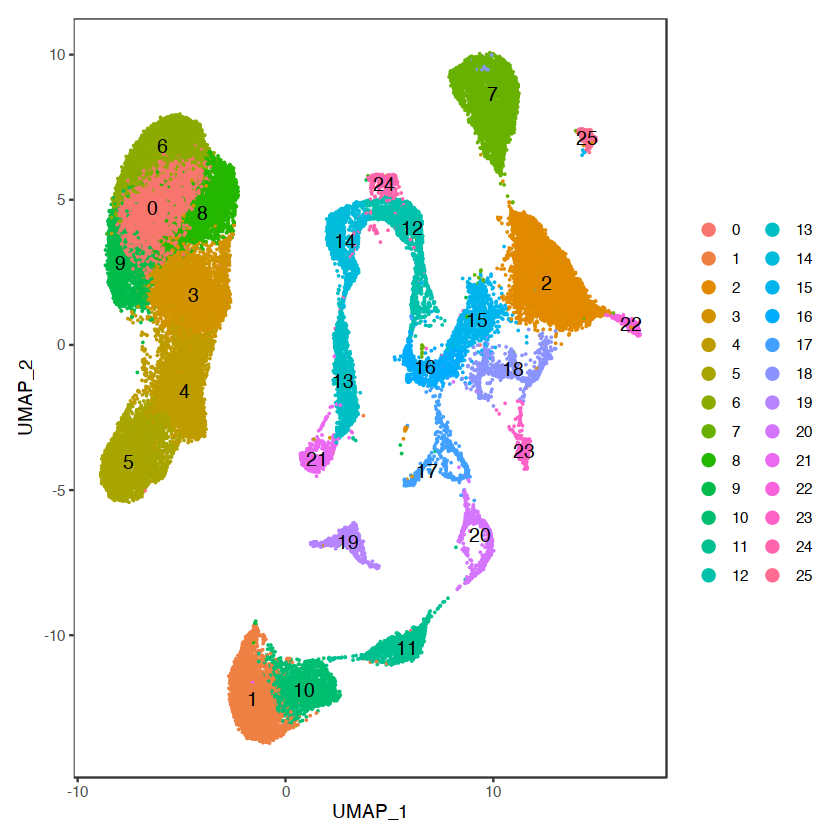

In [3]:
# Normalize and Scale
bm = NormalizeData(bm, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
bm = FindVariableFeatures(bm, selection.method = "vst", nfeatures = 5000, verbose = F)
bm = ScaleData(bm, verbose = F)

# PCA, UMAP visualization and clustering
bm = RunPCA(bm, ndims.print = 1:30, verbose = F)
bm = RunUMAP(bm, dims = 1:30, verbose = F)
bm = FindNeighbors(bm, dims = 1:30, k.param = 30, verbose = F)
bm = FindClusters(bm, resolution = 1, verbose = F)
bm@meta.data$Donor = unlist(strsplit(bm$orig.ident, split = "_"))[c(T,F)]
bm@meta.data$TimePoint = unlist(strsplit(bm$orig.ident, split = "_"))[c(F,T)]
DimPlot(bm, label = TRUE, pt.size = 0.01) + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### Assign cell types to clusters 
This assignment is based on known canonical markers for each hematological cell type

In [4]:
bm = RenameIdents(bm, "0" = "CD4 Naive", "1" = "B", "2" = "Monocyte", "3" = "CD4 Memory", "4" = "CD8 Memory",
                  "5" = "NK", "6" = "CD8 Naive", "7" = "Inflam Mono", "8" = "Inflam T", "9" = "CD4 Naive", "10" = "B",
                  "11" = "Pro B", "12" = "Early Ery", "13" = "Late Ery", "14" = "Early Ery", "15" = "GMP",
                  "16" = "HSC", "17" = "Pro B", "18" = "cDC", "19" = "Plasma", "20" = "Pro B",
                  "21" = "Late Ery", "22" = "Non Cla Mono", "23" = "pDC", "24" = "Early Ery", "25" = "Inflam Mono")
bm$CellType = bm@active.ident

### Batch correct the data using MNN and visualize cell types

In [5]:
bm_mnn = RunFastMNN(object.list = SplitObject(bm, split.by = "Donor"), features = 3000, verbose = F)
bm_mnn = RunUMAP(bm_mnn, dims = 1:30, reduction = "mnn", min.dist = 0.3, verbose = F)

bm_mnn$CellType = factor(bm_mnn$CellType, levels = c("HSC", "GMP", "Monocyte", "Non Cla Mono", "cDC", "pDC", "Inflam Mono",
                                                     "Early Ery", "Late Ery", "Pro B", "B", "Plasma", "CD8 Naive", 
                                                     "CD4 Naive", "Inflam T", "CD4 Memory", "CD8 Memory", "NK"))

### Visualize cells (colored by cell type)

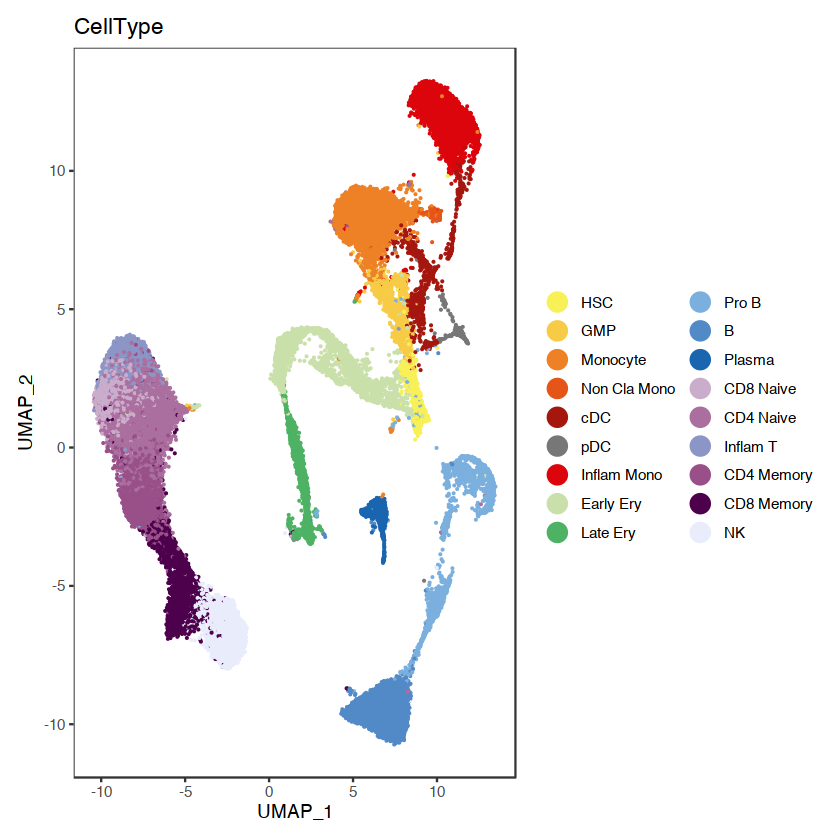

In [6]:
DimPlot(bm_mnn, pt.size=0.1, group.by="CellType") + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
  scale_color_manual(values=c("#f7f056","#f7cb45","#ee8026","#e65518", "#a5170e", "#777777", "#dc050c", "#cae0ab", "#4eb265",
                              "#7bafde","#5289c7","#1965b0","#caaccb","#aa6f9e","#8c96c6","#994f88","#4d004b","#e8ecfb")) +
  guides(color=guide_legend(ncol=2, override.aes = list(size=5)))

### Visualize cells (colored by time point)

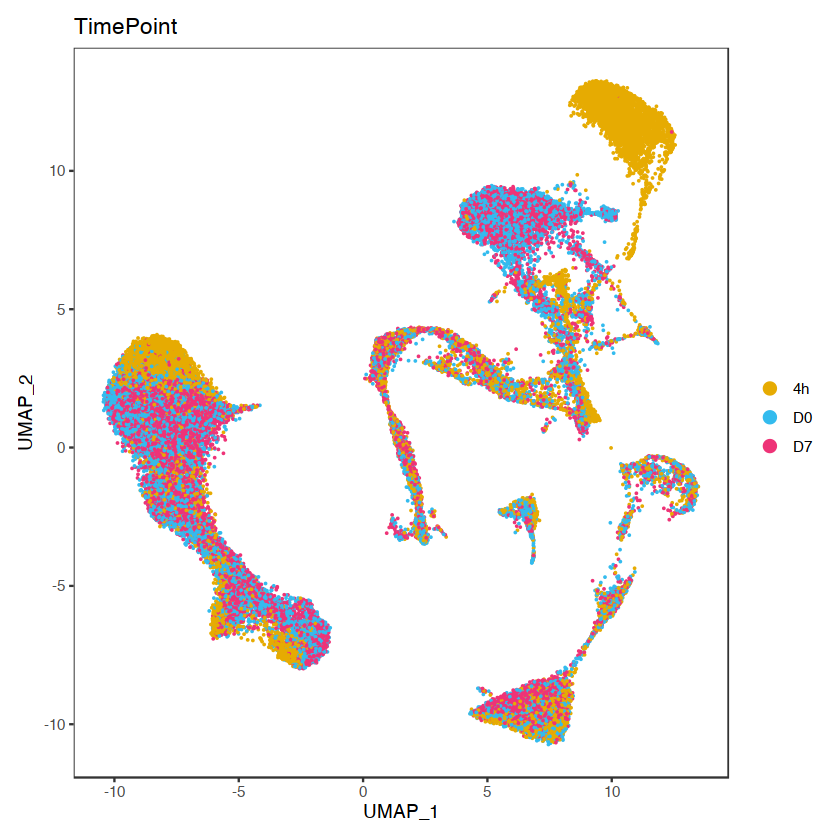

In [7]:
DimPlot(bm_mnn, label = F, pt.size = 0.01, group.by = "TimePoint", shuffle = T) + scale_color_manual(values=c("#e6ab02", "#33bbee", "#ee3377")) +
  theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### Save object
You can save **bm** object to use it in the future or for [other analysis pipelines](https://github.com/fkeramati/LPS-SI/tree/main/Analysis%20Scripts)

In [8]:
saveRDS(bm_mnn, "Bonemarrow_allCells_allTimePoints_MNN_batchCorrected.rds")